# Purpose

This notebook's purpose is to sift through all of the hospital chargemasters and metadata generated via the work already done in [this wonderful repo](https://github.com/vsoch/hospital-chargemaster) (from which I forked my repo). This is where the data engineering for Phase II of this project occurs. For more information on what Phase II is, please see [the README](README.md) for this project. Results from the explorations done in this notebook will be incorporated into a single cleaning script within the repo.

Based upon the originating repo's own README, there's at least some data collection that still needs to be done for completeness (e.g. [data from hospitalpriceindex.com](https://search.hospitalpriceindex.com/hospital/Barnes-Jewish-Hospital/5359?page=1) has to be scraped but they're denying IP addresses that try to do so). However, that is beyond the current scope of this work.

# Background

*Assume everything in this cell is quoted directly from the originating repo README, albeit with some extra content removed for the purposes of streamlining. Anything in italics like this should be assumed to be editorial additions by me.*

**From the original README:**

## Get List of Hospital Pages
We have compiled a list of hospitals and links in the [hospitals.tsv](hospitals.tsv) 
file, generated via the [0.get_hospitals.py](0.get_hospitals.py) script *which pulls these data from [a Quartz article](https://qz.com/1518545/price-lists-for-the-115-biggest-us-hospitals-new-transparency-law/) detailing ~115 hospital URLs from which the authors were able to find chargemasters in one form or another*. 

The file includes the following variables, separated by tabs:

 - **hospital_name** is the human friendly name
 - **hospital_url** is the human friendly URL, typically the page that includes a link to the data.
 - **hospital_id** is the unique identifier for the hospital, the hospital name, in lowercase, with spaces replaced with `-`
   
## Organize Data

Each hospital has records kept in a subfolder in the [data](data) folder. Specifically,
each subfolder is named according to the hospital name (made all lowercase, with spaces 
replaced with `-`). If a subfolder begins with an underscore, it means that I wasn't
able to find the charge list on the hospital site (and maybe you can help?) 
Within that folder, you will find:

 - `scrape.py`: A script to scrape the data
 - `browser.py`: If we need to interact with a browser, we use selenium to do this.
 - `latest`: a folder with the last scraped (latest data files)
 - `YYYY-MM-DD` folders, where each folder includes:
   - `records.json` the complete list of records scraped for a particular data
   - `*.csv` or `*.xlsx` or `*.json`: the scraped data files.

## Parsing
This is likely one of the hardest steps. I wanted to see the extent to which I could
create a simple parser that would generate a single TSV (tab separted value) file
per hospital, with minimally an identifier for a charge, and a price in dollars. If
provided, I would also include a description and code:

 - **charge_code**
 - **price**
 - **description**
 - **hospital_id**
 - **filename**

Each of these parsers is also in the hospital subfolder, and named as "parser.py." The parser would output a data-latest.tsv file at the top level of the folder, along with a dated (by year `data-<year>.tsv`). At some point
I realized that there were different kinds of charges, including inpatient, outpatient, DRG (diagnostic related group) and others called
"standard" or "average." I then went back and added an additional column
to the data:

 - **charge_type** can be one of standard, average, inpatient, outpatient, drg, or (if more detail is supplied) insured, uninsured, pharmacy, or supply. This is not a gold standard labeling but a best effort. If not specified, I labeled as standard, because this would be a good assumption.

# Exploring the Chargemaster Data

OK, I think I have a handle on this, let's take a look at the chargemaster data from @vsoch's repo.

In [4]:
#Make sure any changes to custom packages can be reflected immediately 
#in the notebook without kernel restart
import autoreload
%load_ext autoreload
%autoreload 2

## Reading in the Tabulated Data

OK, there are **a lot** of files to plow through here! And @vsoch was kind enough to try and compile them whenever appropriate in the various hospital/site-specific folders within `data` as `data-latest[-n].tsv` (`-n` indicates that, if the file gets above 100 MB, it's split into `data-latest-1.tsv`, `data-latest-2.tsv`, etc. to avoid going over the GitHub per-file size limit).

Let's try to parse all of these TSV files into a single coherent DataFrame for analysis purposes! The entire `data` folder set is less than 4 GB, and I'm confident that more than half of that is individual XLSX/CSV files, so I think this should be something we can hold in memory easily enough.

...still, we'll use some tricks (e.g. making the sub-dataframes as a generator instead of a list) to ensure optimal memory usage, just to be safe.

In [129]:
import pandas as pd

# Search through the data/hospital-id folders for data-latest[-n].tsv files
# so you can concatenate them into a single DataFrame
from glob import glob, iglob

def load_data(filepath='data/*/data-latest*.tsv'):
    '''
    Re-constitute the DataFrame after doing work outside of the DataFrame in memory, 
    such as correcting and re-running a parser.
    
    Inputs
    ------
    filepath: str. Provides an explicit or wildcard-based filepath for all 
        data files that should be concatenated together
        
    Outputs
    -------
    Returns a single pandas DataFrame that contains all data from the files
        specified by filepath
    '''

    # Setup the full dataframe using iterators/generators to save on memory
    all_files = iglob(filepath)
    individual_dfs = (pd.read_csv(f, delimiter = '\t', 
                                  low_memory = False,
                                 thousands = ',') for f in all_files)

    return pd.concat(individual_dfs, ignore_index=True)

In [14]:
df = load_data()
df.info(memory_usage = 'deep', verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9907857 entries, 0 to 9907856
Data columns (total 6 columns):
charge_code    6563312 non-null object
price          8735057 non-null object
description    8745419 non-null object
hospital_id    9888293 non-null object
filename       9907857 non-null object
charge_type    9907857 non-null object
dtypes: object(6)
memory usage: 3.8 GB


In [6]:
df.head()

,charge_code,price,description,hospital_id,filename,charge_type
0,NaN,1980,Adult semi-private (up to two patients) room a...,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard
1,NaN,1980,Adult room and care in the Transitional Care H...,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard
2,NaN,2310,Adult room and care on the Labor & Delivery unit,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard
3,NaN,1980,Pediatric room and care,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard
4,NaN,2448,Psychiatric room and care,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard


In [7]:
df.tail()

,charge_code,price,description,hospital_id,filename,charge_type
9907852,NaN,113699.36,983 EXTENSIVE O.R. PROCEDURE UNRELATED TO PRIN...,Winter Haven Hospitals,copy-of-msdrg-list-01-15-19.xlsm,drg
9907853,NaN,91145.59,987 NON-EXTENSIVE O.R. PROC UNRELATED TO PRINC...,Winter Haven Hospitals,copy-of-msdrg-list-01-15-19.xlsm,drg
9907854,NaN,101386.94,988 NON-EXTENSIVE O.R. PROC UNRELATED TO PRINC...,Winter Haven Hospitals,copy-of-msdrg-list-01-15-19.xlsm,drg
9907855,NaN,4701.0,989 NON-EXTENSIVE O.R. PROC UNRELATED TO PRINC...,Winter Haven Hospitals,copy-of-msdrg-list-01-15-19.xlsm,drg
9907856,NaN,67846.66,999 UNGROUPABLE,Winter Haven Hospitals,copy-of-msdrg-list-01-15-19.xlsm,drg


## Checking and Cleaning Columns

Since these datasets were all put together by individual parsing scripts that parsed through a bunch of non-standardized data files from different sources, there's almost guaranteed to be leakage of values from one column to another and so on. So we're going to check each column for anomalies and correct them as we go before proceeding any further.

In [20]:
df.columns

Index(['charge_code', 'price', 'description', 'hospital_id', 'filename',
       'charge_type'],
      dtype='object')

### Filename

Since the values in this column come internally from the project data collection process, I expect that this column will be clean and orderly...right?

In [22]:
print(f"There are {df['filename'].nunique()} unique values in this column\n")
df['filename'].value_counts()

There are 705 unique values in this column



hardin-hospital-charge-list.csv                                                  1048575
cdm-hmtw.csv                                                                      404025
UW-Health-Charge-Master-Supplies.xlsx                                             348542
chargemaster-2019.xlsx                                                            245068
cdm-sl.csv                                                                        230406
cdm-west.csv                                                                      230406
cdm-wb.csv                                                                        226581
duh_compliant_cy19.xlsx                                                           210052
drah_compliant_cy19.xlsx                                                          207774
drh_compliant_cy19.xlsx                                                           207246
hospital_chargemaster.xlsx                                                        162657
CMC_Price_Disclosure.

OK, nothing stands out as problematic here. Since every filename should end with `.file_extension`, let's do a quick check that nothing violates that rule.

In [28]:
# Check how many values match the structure of ".letters" at the end
df['filename'].str.contains(r'\.[a-z]+$', case=False).sum() / len(df['filename'].dropna())

0.9918993582567855

Interesting, so a few values don't match. Let's see what they are.

In [32]:
# Return values that don't match what we're expecting
df.loc[~df['filename'].str.contains(r'\.[a-z]+$', case=False),
      'filename']

1279950           geisinger-medical-center
1279951           geisinger-medical-center
1279952           geisinger-medical-center
1279953           geisinger-medical-center
1279954           geisinger-medical-center
1279955           geisinger-medical-center
1279956           geisinger-medical-center
1279957           geisinger-medical-center
1279958           geisinger-medical-center
1279959           geisinger-medical-center
1279960           geisinger-medical-center
1279961           geisinger-medical-center
1279962           geisinger-medical-center
1279963           geisinger-medical-center
1279964           geisinger-medical-center
1279965           geisinger-medical-center
1279966           geisinger-medical-center
1279967           geisinger-medical-center
1279968           geisinger-medical-center
1279969           geisinger-medical-center
1279970           geisinger-medical-center
1279971           geisinger-medical-center
1279972           geisinger-medical-center
1279973    

**Oy vay, looks like we found some anomalies!** These entries clearly have had their `hospital_id` values leak into their `filename` column. We'll need to repair the parser once we're sure we know which one(s) are the problem.

In [33]:
df.loc[~df['filename'].str.contains(r'\.[a-z]+$', case=False),
      'filename'].value_counts()

geisinger-medical-center                   15318
geisinger-holy-spirit-hospital             14531
geisinger-lewistown-hospital               12943
geisinger-wyoming-valley-medical-center    11734
geisinger-bloomsburg-hospital              10272
geisinger-community-medical-center          9524
geisinger-jersey-shore-hospital             5938
Name: filename, dtype: int64

In [35]:
df[~df['filename'].str.contains(r'\.[a-z]+$', case=False)].head()

,charge_code,price,description,hospital_id,filename,charge_type
1279950,NaN,522.00,"Electrocardiogram, routine ECG with at least 1...",CDM-Geisinger-Medical-Ctr-01-01-19.csv,geisinger-medical-center,standard
1279951,NaN,1301.00,External electrocardiographic recording up to ...,CDM-Geisinger-Medical-Ctr-01-01-19.csv,geisinger-medical-center,standard
1279952,NaN,171.00,"Rhythm ECG, 1-3 leads; tracing only without in...",CDM-Geisinger-Medical-Ctr-01-01-19.csv,geisinger-medical-center,standard
1279953,NaN,882.00,External electrocardiographic recording up to ...,CDM-Geisinger-Medical-Ctr-01-01-19.csv,geisinger-medical-center,standard
1279954,NaN,154.00,Transtelephonic rhythm strip pacemaker evaluat...,CDM-Geisinger-Medical-Ctr-01-01-19.csv,geisinger-medical-center,standard


**Yup, it's all of the data from the `geisinger-medical-center` data folder.** I'll take a look at the parser and correct it then re-import then DataFrame and see if it's improved at all.

In [37]:
df = load_data()

# Is it fixed? Shouldn't return any values
df.loc[~df['filename'].str.contains(r'\.[a-z]+$', case=False),
      'filename'].value_counts()

Series([], Name: filename, dtype: int64)

**That did the trick!** At this point, we can be sure that all of the entries in the `filename` column have file extensions, which seems like a reasonable data check. Onwards!

### Hospital ID

Again, since these data are essentially internal to this project, I'm thinking that this one will be good to go already or require minimal cleaning. Here's hoping...

Note that it's my intent to convert these into more human-readable names once I've cleaned them up so that they'll be able to match with the Centers for Medicare and Medicaid (CMS) hospital names and can then be mapped to standardized hospital identifiers.

In [38]:
print(f"There are {df['hospital_id'].nunique()} unique values in this column\n")
df['hospital_id'].value_counts()

There are 372 unique values in this column



the-methodist-hospital-(houston)                         1091418
riverside-methodist-hospital                             1073993
methodist-hospital-(san-antonio)                          726295
university-of-wisconsin-madison-hospitals-and-clinics     361026
scott-and-white-memorial-hospital                         309386
rainbow-babies-and-childrens-hospital                     255945
duke-university-hospital                                  210052
duke-raleigh-hospital                                     207774
duke-regional-hospital                                    207246
university-of-iowa-hospitals-and-clinics                  162658
carolinas-medical-center                                  152728
university-hospitals-case-medical-center                  148350
uc-san-diego-medical-center                               146023
university-of-north-carolina-hospital                     144148
morristown-memorial-hospital                              124497
ucsd-medical-center      

**OK, it looks like I'll need to correct some parser issues here too.**

* At first I thought I could use the names of the folders in the `data/` folder for the project as the gold standard of `hospital_id` values, but there's only 115 of those and possibly twice as many `hospital_id` values (correcting for the erroneous ones we're seeing here). The Geisinger Medical Center ones alone all are within the `geisinger-medical-center` folder even though there are actually 7-8 unique `hospital_id` values.
* Let's start by looking for values that don't have at least one hyphen with letters on either side of it.
    * After correcting for these, we can also look to see if any low-value-count anomalies remain and go from there.

In [46]:
# Find hospital_id values that don't have at least one hyphen with letters on either side of it

df.dropna(subset=['hospital_id']).loc[~df['hospital_id'].dropna().
                                      str.contains(r'[a-z]+-[a-z]+',
                                                   case=False),
                                      'hospital_id'].value_counts()


Heartland                                               51513
Stanislaus Surgical Hospital                            35964
Shawnee_x0020_Mission                                   34029
baptist                                                 26867
California Pacific Medical Center                       22033
Sutter Medical Center Sacramento                        19920
Daytona                                                 18359
Alta Bates Summit Medical Center - Alta Bates Campus    18198
Sutter Roseville Medical Center                         17997
TH_x0020_Huguley                                        17859
Tampa                                                   17771
Alta Bates Summit Medical Center - Summit Campus        17326
Fish                                                    17310
Waterman                                                17278
Wesley_x0020_Chapel                                     17265
DeLand                                                  17160
Henderso

Interesting. A few things to note:

1. 'x0020' seems to be the space character for some text encodings
2. It looks like the vast majority of these are hospital names that never translated into `hospital_id` values for some reason, with some instances of `description` or `charge_code` values also leaking into these.
3. Quick review of many of these indicates they are hospital names (or stems of names) of hospitals from the `advent-health/` directory, which has a single parser. So if I can correct that one, I may make substantial progress in one fell swoop!

Since we know that the only (hopefully) fully cleaned column is `filename`, we'll have to use that as our guide. I'll first focus on the parsers for those hospitals I can identify and see if those are easy fixes and hopefully by clearing away that clutter we can correct the vast majority of the problem children here. I'll then tackle what remains individually. And at the end of it all, I'll also need too look at how to correct the records that have `hospital_id == np.nan`.

#### Correct Parsers Wherein `hospital_id == hospital name`

In [51]:
df.loc[df['hospital_id'] == 'Heartland']

,charge_code,price,description,hospital_id,filename,charge_type
386068,100008,142.4,IV INFUS SEQ INFUS TO 1HR,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386069,100009,648.018,IV INFUS NON CHEMO 1HR,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386070,100010,220.565,IV INFUS NON CHEMO ADD HR,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386071,100011,101.18,IV INFUS CONCURRENT INFUS,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386072,100028,160.5,DIRECT ADMIT OBSERVATION,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386073,100056,0.01,R&B CONDITION 44 BCE ONLY,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386074,100610,319.22,NEW PT LEVEL 1 OB VISIT,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386075,100611,176.51,EST PT LEVEL 1 OB VISIT,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386076,100612,502.1,NEW PT LEVEL 2 OB VISIT,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard
386077,100613,277.11,EST PT LEVEL 2 OB VISIT,Heartland,/home/vanessa/Documents/Dropbox/Code/database/...,standard


In [55]:
df.dropna(subset=['hospital_id']).loc[df['hospital_id'].dropna().str.startswith('adventhealth'),
                                     'hospital_id'].value_counts()

adventhealth-altamonte-springs    19190
adventhealth-orlando              19190
adventhealth-east-orlando         19190
adventhealth-winter-garden        19190
adventhealth-winter-park          19190
adventhealth-celebration          19190
adventhealth-kissimmee            19190
adventhealth-for-children         19190
adventhealth-apopka               19190
Name: hospital_id, dtype: int64

**Interesting! It looks like the majority of the data files for advent health don't have proper IDs in the database.** Likely this means there's some common thread in the parser that, when corrected, will cause a lot of my `hospital_id` problems to evaporate. Or at least I hope so!

**It looks like the parser was taking the raw hospital IDs from the data files (the capitalized and space-delimited names) and not modifying them.** So I simply modified them to be all lowercase and replace spaces with hyphens. Let's see how that goes!

...this is going to take a while, given the sheer amount of data being parsed. In the meantime, let's address the hospitals that *aren't* Advent Health.

In [68]:
df.loc[df['hospital_id'] == 'Stanislaus Surgical Hospital']

,charge_code,price,description,hospital_id,filename,charge_type
1118170,DRG-470,43664,MAJOR HIP AND KNEE JOINT REPLACEMENT OR REATTA...,Stanislaus Surgical Hospital,chargemaster-2019.json,drg
1118171,DRG-483,59731,MAJOR JOINT/LIMB REATTACHMENT PROCEDURE OF UPP...,Stanislaus Surgical Hospital,chargemaster-2019.json,drg
1164709,11,4760,OBTRYX CURVED SLING,Stanislaus Surgical Hospital,chargemaster-2019.json,inpatient
1164710,50296,3439,APPLICATION OF MULTI-LAYER COMPRESSION S,Stanislaus Surgical Hospital,chargemaster-2019.json,inpatient
1164711,339078,600,US AORTA ILLIAC COMP,Stanislaus Surgical Hospital,chargemaster-2019.json,inpatient
1164712,500001,781.9,IV INFUSION THERAPY - 96365,Stanislaus Surgical Hospital,chargemaster-2019.json,inpatient
1164713,500002,158.3,IV INFUSION THERAPY - 96366,Stanislaus Surgical Hospital,chargemaster-2019.json,inpatient
1164714,500003,230.8,IV INFUSION THERAPY - 96367,Stanislaus Surgical Hospital,chargemaster-2019.json,inpatient
1164715,500004,4825,SURGERY FIRST 30 MINUTES,Stanislaus Surgical Hospital,chargemaster-2019.json,inpatient
1164716,500005,693,SURGERY SUBSEQUENT 15 MINUTES,Stanislaus Surgical Hospital,chargemaster-2019.json,inpatient


Based upon a quick search of the `data/` folder, it looks like the Stanislaus entries are probably coming from the `california-pacific-medical-center-r.k.-davies-medical-center/` and `st.-luke’s-hospital-(san-francisco)` folders, the `chargemaster-2019.xlsx` and `chargemaster-2019.json` files, resp.

In [75]:
# Take a look at St. Luke's first - stealing code from parse.py to make this simple
import codecs, json

filename = "data/st.-luke’s-hospital-(san-francisco)/latest/chargemaster-2019.json"
with codecs.open(filename, "r", encoding='utf-8-sig', errors='ignore') as filey:
    content = json.loads(filey.read())
    
names = set()

for row in content['CDM']:
    if 'HOSPITAL_NAME' in row:
        names.add(row['HOSPITAL_NAME'])
        
print(names)

{'Alta Bates Summit Medical Center - Summit Campus', 'Sutter Delta Medical Center', 'Mills-Peninsula Health Services', 'Sutter Solano Medical Center', 'Memorial Medical Center, Modesto', 'Sutter Lakeside Hospital', 'Alta Bates Summit Medical Center - Alta Bates Campus', 'Sutter Center for Psychiatry', 'Sutter Auburn Faith Hospital', 'California Pacific Medical Center', 'Sutter Tracy Community Hospital', 'Sutter Coast Hospital', 'St. Luke’s Hospital', 'Sutter Medical Center Sacramento', 'Novato Community Hospital', 'Sutter Maternity & Surgery Center of Santa Cruz', 'Menlo Park Surgical Hospital', 'Sutter Amador Hospital', 'Sutter Davis Hospital', 'California Pacific Medical Center - Davies Campus', 'Eden Medical Center', 'Sutter Roseville Medical Center', 'Sutter Surgical Hospital North Valley', 'California Pacific Medical Center - Pacific Campus', 'Stanislaus Surgical Hospital', 'Sutter Kahi Mohala', 'Memorial Hospital Los Banos', 'Sutter Medical Center of Santa Rosa'}


**Alrighty, it's pretty clear that Stanislaus is in this dataset.** Let's check the other one too.

Fun fact, for some reason CPMC-RKDMC has both a JSON and an XLSX file! The parser only pays attention to the XLSX file though, so that's all we'll worry about too (likely one is just a different file format version of the other).

In [78]:
# Now for CPMC-RKDMC
filename = "data/california-pacific-medical-center-\
r.k.-davies-medical-center/latest/chargemaster-2019.xlsx"
temp = pd.read_excel(filename)

In [79]:
temp.dropna(subset=['HOSPITAL_NAME'])[temp['HOSPITAL_NAME'].dropna().str.contains('Stanislaus')]

,FACILITY,CMS_PROV_ID,HOSPITAL_NAME,SERVICE_SETTING,CDM,DESCRIPION,REVENUE_CODE,CHARGE
455,SSH,50726,Stanislaus Surgical Hospital,DRG,DRG-470,MAJOR HIP AND KNEE JOINT REPLACEMENT OR REATTA...,NaN,43664.00
456,SSH,50726,Stanislaus Surgical Hospital,DRG,DRG-483,MAJOR JOINT/LIMB REATTACHMENT PROCEDURE OF UPP...,NaN,59731.00
47030,SSH,50726,Stanislaus Surgical Hospital,IP,11,OBTRYX CURVED SLING,278.0,4760.00
47031,SSH,50726,Stanislaus Surgical Hospital,IP,50296,APPLICATION OF MULTI-LAYER COMPRESSION S,360.0,3439.00
47032,SSH,50726,Stanislaus Surgical Hospital,IP,339078,US AORTA ILLIAC COMP,402.0,600.00
47033,SSH,50726,Stanislaus Surgical Hospital,IP,500001,IV INFUSION THERAPY - 96365,260.0,781.90
47034,SSH,50726,Stanislaus Surgical Hospital,IP,500002,IV INFUSION THERAPY - 96366,260.0,158.30
47035,SSH,50726,Stanislaus Surgical Hospital,IP,500003,IV INFUSION THERAPY - 96367,260.0,230.80
47036,SSH,50726,Stanislaus Surgical Hospital,IP,500004,SURGERY FIRST 30 MINUTES,360.0,4825.00
47037,SSH,50726,Stanislaus Surgical Hospital,IP,500005,SURGERY SUBSEQUENT 15 MINUTES,360.0,693.00


In [85]:
for row in temp.iterrows():
    print(row)
    break

(0, FACILITY                                                        ABMC
CMS_PROV_ID                                                    50305
HOSPITAL_NAME      Alta Bates Summit Medical Center - Alta Bates ...
SERVICE_SETTING                                                  drg
CDM                                                          DRG-064
DESCRIPION         INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...
REVENUE_CODE                                                     NaN
CHARGE                                                         94946
Name: 0, dtype: object)


In [84]:
temp.head()

,FACILITY,CMS_PROV_ID,HOSPITAL_NAME,SERVICE_SETTING,CDM,DESCRIPION,REVENUE_CODE,CHARGE
0,ABMC,50305,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-064,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,NaN,94946.0
1,ABMC,50305,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-189,PULMONARY EDEMA & RESPIRATORY FAILURE,NaN,52947.0
2,ABMC,50305,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-190,CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC,NaN,54264.0
3,ABMC,50305,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-193,SIMPLE PNEUMONIA & PLEURISY W MCC,NaN,51524.0
4,ABMC,50305,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-194,SIMPLE PNEUMONIA & PLEURISY W CC,NaN,34576.0


In [104]:
temp.loc[0:2,'HOSPITAL_NAME'].astype(str).str.lower().str.replace(" ", "-")

0    alta-bates-summit-medical-center---alta-bates-...
1    alta-bates-summit-medical-center---alta-bates-...
2    alta-bates-summit-medical-center---alta-bates-...
Name: HOSPITAL_NAME, dtype: object

In [105]:
temp.loc[0:2]

,FACILITY,CMS_PROV_ID,HOSPITAL_NAME,SERVICE_SETTING,CDM,DESCRIPION,REVENUE_CODE,CHARGE
0,ABMC,50305,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-064,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,NaN,94946.0
1,ABMC,50305,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-189,PULMONARY EDEMA & RESPIRATORY FAILURE,NaN,52947.0
2,ABMC,50305,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-190,CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC,NaN,54264.0


In [106]:
temp[['FACILITY', 'CMS_PROV_ID']] = temp[['HOSPITAL_NAME', 'SERVICE_SETTING']]
temp.loc[0:2]

,FACILITY,CMS_PROV_ID,HOSPITAL_NAME,SERVICE_SETTING,CDM,DESCRIPION,REVENUE_CODE,CHARGE
0,Alta Bates Summit Medical Center - Alta Bates ...,drg,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-064,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,NaN,94946.0
1,Alta Bates Summit Medical Center - Alta Bates ...,drg,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-189,PULMONARY EDEMA & RESPIRATORY FAILURE,NaN,52947.0
2,Alta Bates Summit Medical Center - Alta Bates ...,drg,Alta Bates Summit Medical Center - Alta Bates ...,drg,DRG-190,CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC,NaN,54264.0


Yup, this is one of them too! OK, now we know what hospital data folders we're looking at (who was this Stanislaus person anyhow? Quite the surgical philanthropist...). The problem here is that each of these chargemasters covers data for multiple hospitals, making it so that the `records.json` URI isn't terribly useful.

What I'm going to do instead is modify them so that the hospital names extracted are of a similar format to all other hospital IDs in our dataset.

In [130]:
# Find hospital_id values that don't have at least one hyphen with letters on either side of it
df = load_data()
df.dropna(subset=['hospital_id']).loc[~df['hospital_id'].dropna().
                                      str.contains(r'[a-z]+-[a-z]+',
                                                   case=False),
                                      'hospital_id'].value_counts()


baptist                                                 26867
Mease Countryside Hospital                              12554
Morton Plant Hospital                                   12390
Stanislaus Surgical Hospital                            11988
St. Anthony's Hospital                                  11725
MGH Standard Charge File.xlsx                           10019
Bartow Regional Medical Center                           9912
South Florida Baptist Hospital                           9889
North Central Baptist Hospital                           9848
Baptist Medical Center                                   9831
Northeast Baptist Hospital                               9831
Saint Luke's Baptist Hospital                            9815
Mission Trail Baptist Hospital                           9807
BayCare Alliant Hospital                                 8682
Morton Plant North Bay Hospital                          7513
Resolute Health Hospital                                 7432
Californ

**Very nice! By fixing those few parsers, we reduced the number of problem IDs from more than 350 to only a little more than 100!** There's still a ways to go, but I'm hopeful. Let's take a look at that `baptist` entry...

#### Correct Parsers and Data for Remaining Problem IDs

#### Correct Records Wherein `hospital_id == np.nan`

Note that, from my experience parsing the Stanislaus Surgical Hospital data, these NaN values could be coming from the parsing process itself, even when it's properly done (e.g. source chargemaster doesn't have actually hospital names to pull for some rows for some reason, not that one column got confused with another).

#### Hospital ID -> Hospital Name

Now I'll convert this cleaned up column of "IDs" that are actually just the hospital names with hyphens instead of spaces into regular hospital names so that I can match them to CMS records and combine the CMS hospital data in seamlessly.

Ultimately, what I'll do is create names based upon the mapping of URIs to names in the individual `results.json` files in `data/<hospital group>/latest/`

### Price

As this should be a continuous variable (maybe with some commas or dollar signs to pull out, but otherwise just float values), determining what are reasonable values for this column and what are anomalous should be easy...ish.

### Charge Type

I think these are again internally-derived labels for this project (that are also totally valid categories of charges mind you) and, as such, likely to not have too many values to contend with, making cleaning them pretty seamless (I hope).

### Charge Code

This one will be tough. There's theoretically nothing limiting a hospital from making its own random charge code mappings, alphanumeric values being fair game. Likely there will be a few oddballs that stand out as being problematic, but I may not be able to catch all of the problems in this one.

That all being said, this isn't a critical field to begin with, and hopefully most corrections in the earlier columns will correct most of the problems in this one. My priority will be to find any entries in this column that are clearly meant to be in the other columns (especially `description`) so that I can rely on them at this column's expense.

### Description

This one is the trickiest and the most important. It can theoretically have any value and will be what I need to aggregate on in order to find trends in prices across hospitals. Hopefully by fixing all of the other columns prior to this one I'll have minimized the cleaning to be done here.

## Optimize the DataFrame

This dataframe is quite large (almost 4GB in memory!) and that's likely to cause all sorts of problems when it comes time tofilepathnalysis. So we'll need to make sure we understand the nature of each column's data and then optimize for it (after potentially correcting for things like strings that are actually numbers).

To start with, let's check out the nature of the data in each column:

1. How often do charge codes exist?
2. We'll check, but likely that description exists for most
3. Other than decimal numbers, what values are in price?
4. What are all of the different charge type values, and which ones can we filter out (e.g. drg)?
    * Do charge codes get embedded in descriptions a lot, like what we see in df.tail()? Or is this something that is only present for non-standard charge_type?

In [3]:
# In case you need to reinitialize df after experimenting...

#Make sure any changes to custom packages can be reflected immediately 
#in the notebook without kernel restart
import autoreload
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

df = pd.read_csv('data/all_hospitals-latest.csv', index_col = 0, low_memory = False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# First, let's get a better handle on unique values, so we can figure out what fields make
# sense as categoricals and what ones definitely don't

unique_vals = pd.DataFrame(df.nunique()).rename(columns = {0: 'number of unique values'})
unique_vals['fraction of all values'] = round(unique_vals['number of unique values'] / len(df), 2)
unique_vals['data type'] = df.dtypes

# Assumes strings are involved if feature should be categorical,
# although may not be true for numerically-coded categoricals
unique_vals['make categorical?'] = (unique_vals['fraction of all values'] < 0.5) \
& (unique_vals['data type'] == 'object')
unique_vals

,number of unique values,fraction of all values,data type,make categorical?
charge_code,1714542,0.17,object,True
price,720751,0.07,object,True
description,2477488,0.25,object,True
hospital_id,379,0.00,object,True
filename,705,0.00,object,True
charge_type,12,0.00,object,True


In [18]:
df['description'].value_counts()

T e c h                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       250702
ANCHOR/SCREW FOR BONE-TO-BONE OR SOFT TISSUE-TO-BONE (IMPLANTED)                                                   

In [19]:
df['hospital_id'].value_counts()

the-methodist-hospital-(houston)                         1091418
riverside-methodist-hospital                             1073993
methodist-hospital-(san-antonio)                          726295
university-of-wisconsin-madison-hospitals-and-clinics     361026
scott-and-white-memorial-hospital                         309386
rainbow-babies-and-childrens-hospital                     255945
duke-university-hospital                                  210052
duke-raleigh-hospital                                     207774
duke-regional-hospital                                    207246
university-of-iowa-hospitals-and-clinics                  162658
carolinas-medical-center                                  152728
university-hospitals-case-medical-center                  148350
uc-san-diego-medical-center                               146023
university-of-north-carolina-hospital                     144148
morristown-memorial-hospital                              124497
ucsd-medical-center      

**Interesting. There are so many records with repeat information that we can change the dtype of pretty much all of them to be categorical.** Here's what we're going to do:

1. `charge_code`, `price`, and `description`: I'm not going to convert these to categoricals
    * `charge_code` and `description`: while from a data perspective these would likely be better handled in memory by making anything categorical that has so few unique values that the count of them is less than 50% of the count of all rows, it doesn't make sense to make these fields categoricals, as that implies they are drawing from a common data reference. That's simply not the case.
        * Given that two different hospitals can have the charge code `1001` refer to two totally different procedures/consumables, there's no reason to add confusion by treating these in the dataset like they have the same meaning. 
        * The same logic goes for the description field (although that one has me scratching my head a bit, as I'd expect it to be a bit more free text in nature and thus not likely to have repeated values)
    * `price`: this should be a continuous variable, not a categorical one!
2. `hospital_id`, `filename`, and `charge_type`: these are classic examples of categorical variables and we should convert them.
    * That being said, it's pretty clear from a very brief look at the unique values in the `hospital_id` field that something is fishy here and that likely some of the parsers have failed to work properly. So it looks like we'll need to parse each column separately and make corrections before proceeding further.

### Categorically Annoying

In [7]:
# Make categorical columns where appropriate
cat_cols = ['hospital_id', 'filename', 'charge_type']

for col in cat_cols:
    df.loc[:, col] = df.loc[:, col].astype('category')

df['charge_type'].cat.categories

Index(['drg', 'inpatient', 'insurance', 'insured-inpatient',
       'insured-outpatient', 'outpatient', 'pharmacy', 'standard', 'supply',
       'uninsured', 'uninsured-inpatient', 'uninsured-outpatient'],
      dtype='object')

In [8]:
df.info(memory_usage = 'deep', verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9907857 entries, 0 to 9907856
Data columns (total 6 columns):
charge_code    6563312 non-null object
price          8735057 non-null object
description    8745419 non-null object
hospital_id    9888293 non-null category
filename       9907857 non-null category
charge_type    9907857 non-null category
dtypes: category(3), object(3)
memory usage: 1.9 GB


**Nice! We cut the memory usage in half!** OK, on to less obvious optimizing!

### Description and Charge Code Fields

In [9]:
# What do our missing values look like? How sparse are these data?

missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total missing'})
missing['percent missing'] = round(missing['total missing'] / len(df),2)
missing.sort_values('total missing', ascending = False)
missing

,total missing,percent missing
charge_code,3344545,0.34
price,1172800,0.12
description,1162438,0.12
hospital_id,19564,0.00
filename,0,0.00
charge_type,0,0.00


**Looks like we have description text for all but 12% of the data.** Not bad.

In [10]:
# How often do charge codes exist?
df['charge_code'].describe()

count     6563312
unique    1615754
top          1001
freq        67961
Name: charge_code, dtype: object

In [11]:
df['charge_code'].value_counts()

1001                                                                                                                                                                                                                                                                                                               67961
C1776                                                                                                                                                                                                                                                                                                              39701
301.0                                                                                                                                                                                                                                                                                                              28355
361.0                                                        

**Quite a few different charge codes, with lots of different possible values.** Given that charge codes are likely a somewhat-random "unique" identifiers (air quotes because I'm suspicious of any large entity's data management practices until that suspicion is proven unwarranted). Nothing to see here.

*OK, let's get to the meat of it, the thing that's actually most interesting (arguably): the price!*

### The Price Column, AKA The Super Important Yet Extremely Messy Column

In [12]:
# Separate out only the price rows that are non-numeric

df['price'].dropna().apply(type).value_counts()

<class 'str'>    8735057
Name: price, dtype: int64

**So about half of the non-null prices are `str` type.** Now we need to figure out what those strings actually are.

In [13]:
# Look at only string prices

df.loc[df['price'].apply(type) == str,'price']

0               1980
1               1980
2               2310
3               1980
4               2448
5               1980
6               3917
7               6272
8               8010
9               8010
10              8010
11              6272
12              3971
13               356
14               587
15               940
16              1535
17              2808
18              4128
19               114
20               207
21               303
22               358
23               441
24               140
25               140
26               140
27               303
28               358
29               441
             ...    
9907827     42609.08
9907828     17784.24
9907829      53461.5
9907830     29037.21
9907831     41134.92
9907832     44698.45
9907833     18743.77
9907834     57341.27
9907835     17131.68
9907836     25042.51
9907837    120471.76
9907838       1393.0
9907839     22365.63
9907840     24346.83
9907841     11872.24
9907842     81348.51
9907843     6

**Huh, how odd. These strings all look like regular old float values.** Why is pandas importing them as strings? Let's force the column to be float type and then we'll see how our missing values change (since we can force non-numeric strings to be `NaN`)

In [14]:
# Convert price to be float type, then see if missing['total_missing'] changes

missing_price_initial = missing.loc['price','total missing']

delta = pd.to_numeric(df['price'], errors = 'coerce').isnull().sum() - missing_price_initial
delta

294073

**OK, so we see about 300K of the 4.67M string values become `NaN` when we do this numeric conversion. That's not ideal.** Looks like we're losing a lot of data with this conversion, is there a better way? Or should we just consider this an acceptable loss?

In [15]:
# How to filter so we can see a sample of the ~300K true non-float strings in price
# so we can get an idea as to how to deal with them?

# Show only the prices that are null after numeric conversion
df.loc[pd.to_numeric(df['price'], errors = 'coerce').isnull(), 'price']

762340      5,000
762342      1,768
762348      8,332
762349      2,758
762350      1,581
762352      2,126
762353      1,457
762357      2,125
762358      1,689
762361      4,949
762363      2,773
762364     13,801
762365      7,425
762366      8,035
762367      7,996
762370     32,926
762371     19,395
762372      2,831
762373     10,695
762400      1,019
762401      1,019
762406      1,248
762409      1,114
762414      4,519
762416      4,557
762419      6,418
762420     27,404
762421      8,976
762422      1,458
762423      6,418
            ...  
9897874      -   
9897876      -   
9897884      -   
9897902      -   
9897903      -   
9897912      -   
9897926      -   
9897945      -   
9897977      -   
9897978      -   
9898026      -   
9898027      -   
9898034      -   
9898037      -   
9898038      -   
9898041      -   
9898042      -   
9898052      -   
9898057      -   
9898058      -   
9898070      -   
9898081      -   
9898086      -   
9898096      -   
9898304   

**Ah, I see the issues here! We've got commas making numbers look like they're not numbers, and this weird ' -   ' string that must be a certain hospitals equivalent of `null`.** Let's correct for these!

The `null` string is one space, following by a hyphen and three spaces.

In [16]:
# Set ' -   ' to proper NaN

import numpy as np

df['price'].replace(' -   ', np.nan, inplace = True)

In [17]:
# What are the values that contain commas?

df.loc[df['price'].str.contains(r'\d,\d', na = False), 'price']

762340                      5,000
762342                      1,768
762348                      8,332
762349                      2,758
762350                      1,581
762352                      2,126
762353                      1,457
762357                      2,125
762358                      1,689
762361                      4,949
762363                      2,773
762364                     13,801
762365                      7,425
762366                      8,035
762367                      7,996
762370                     32,926
762371                     19,395
762372                      2,831
762373                     10,695
762400                      1,019
762401                      1,019
762406                      1,248
762409                      1,114
762414                      4,519
762416                      4,557
762419                      6,418
762420                     27,404
762421                      8,976
762422                      1,458
762423        

**Oh goodie, there are *ranges* of dollar amounts that we have to worry about!** Fantastic, just fantastic. These hospitals sure don't like making this easy, do they?

Here's the plan:
1. Strip dollar signs from all of these strings. They're superfluous and just make things complicated
2. Split strings on the string ' - '
3. Remove commas and cast results as float values
    * Any rows with `NaN` for the second split column are just regular comma-in-the-thousands-place numbers. Leave them alone for the moment
    * Any with non-null values in the second column: take the average of the two columns and overwrite the first column with the average. This midpoint value will be considered the useful estimate of the cost
4. Push the first column values (now overwritten in the case of ranges of values to be the midpoints) back into their places in the `price` column and continue hunting for edge cases

In [18]:
# Replace effectively null prices with np.nan

df.loc[df['price'] == '-', 'price'] = np.nan

In [19]:
def remove_silly_chars(row):
    '''
    It is assumed that this will be used as part of a Series.apply() call.
    
    Takes in an element of a pandas Series that should be a string representation 
    of a price or a range of prices and spits back the string without any thousands
    separators (e.g. commas) or dollar signs. If it detects that there's a range of
    prices being provided (e.g. $1.00 - $2.00), it returns the midpoint of the range.
    
    Parameters
    ----------
    row: str. The string representation of a price or range of prices.
    
    
    Returns
    -------
    float. The price (or midpoint price if a range was given in row)
    '''
    
    # Replace '$', ',', and '-' with empty strings, splitting on the hyphen
    price_strings = row.replace('$','').replace(',','').split('-')
    
    
    # Strip leading and trailing whitespace from list of split strings
    # and take the average of the different prices from the original range,
    # returning it as a float value
    
    # If ValueError raised, assume there were invalid characters and
    # set to np.nan
    
    try:
        return pd.Series([float(i.strip()) for i in price_strings]).mean()
    
    except ValueError: 
        return np.nan

In [20]:
# When only digits + commas + $, convert to only digits
# Also take average if multiple value range provided in string
ix = df['price'].str.contains(r'\d,\d|\$\d', na=False, case=False)
df.loc[ix, 'price'] = df.loc[ix,'price'].apply(remove_silly_chars)                             

**OK, now that we've cleaned up a lot of those strings so that they can be proper floats, how many bad strings are we left with?** When we ran this check prior to the `$` and `,` cleaning process, we had about 300K records coming up as null after the numeric conversion that weren't null previously. What does it look like now?

In [21]:
# Convert price to be float type, then see if missing['total_missing'] changes

missing_price_initial = missing.loc['price','total missing']

delta = pd.to_numeric(df['price'], errors = 'coerce').isnull().sum() - missing_price_initial
delta

206898

**SIGH. Now we're done to 200K, but that's not awesome.** At this point, I'm fine with it. We'll lose about 2.1% of these that may not appropriately be null (although most probably should be), but anything else I've tried to pare it down further actually makes things worse, so I say we're good now!

In [22]:
# Coerce any obvious float strings to floats
df.loc[:, 'price'] = pd.to_numeric(df['price'], errors = 'coerce')

In [23]:
df.info(memory_usage = 'deep', verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9907857 entries, 0 to 9907856
Data columns (total 6 columns):
charge_code    6563312 non-null object
price          8528159 non-null float64
description    8745419 non-null object
hospital_id    9888293 non-null category
filename       9907857 non-null category
charge_type    9907857 non-null category
dtypes: category(3), float64(1), object(2)
memory usage: 1.5 GB


In [24]:
df['price'].describe()

count    8.528159e+06
mean     8.959729e+06
std      1.928350e+08
min     -1.298600e+04
25%      1.590300e+02
50%      9.020000e+02
75%      4.449000e+03
max      1.000000e+10
Name: price, dtype: float64

**Ah nuts, looks like we have some unreasonable ranges on these data.** If I had to guess, likely these are issues with non-price floats being inserted into the `price` column incorrectly by individual hospital chargemaster parsers. Let's take a quick look at these data, identify the outliers, and see if we can fix them (and what the magnitude of the problem is).

In [28]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

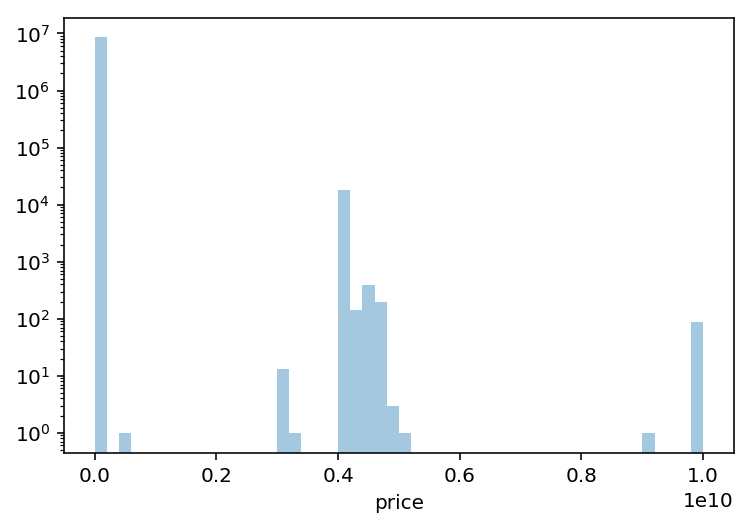

In [33]:
g = sns.distplot(df['price'].dropna(), kde = False)

g.axes.set_yscale('log')

**WHOA. The x-axis goes up to \\$10B USD?!** I'm going to assume that this is unreasonable...

In fact, looks like we have a non-trivial amount of data above \\$1B! That's ludicrous. Let's take a closer look in the \\$1M to \\$10B scale.

In [52]:
df.loc[(df['price'] >= 1E6) & (df['price'] <= 1E10), 'price'].describe()

count    1.871500e+04
mean     4.080677e+09
std      5.740180e+08
min      1.005042e+06
25%      4.050066e+09
50%      4.050233e+09
75%      4.090032e+09
max      1.000000e+10
Name: price, dtype: float64

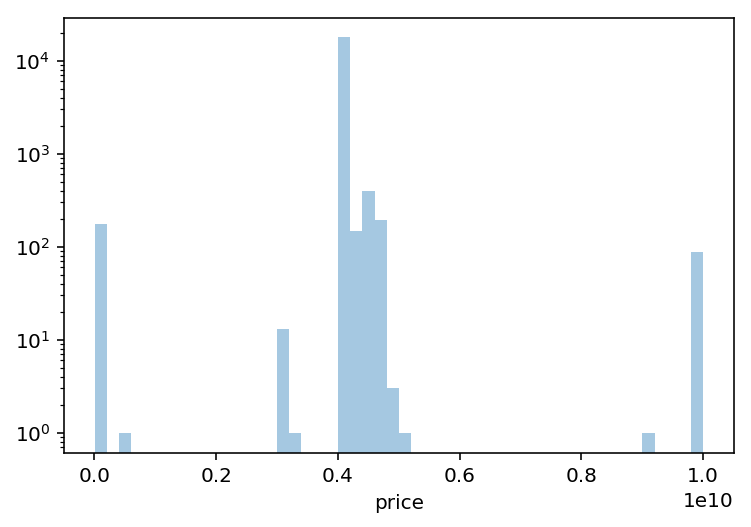

In [55]:
g = sns.distplot(df.loc[(df['price'] >= 1E6) & (df['price'] <= 1E10), 'price'].dropna(),
                 kde=False)

g.axes.set_yscale('log')

In [57]:
df.loc[(df['price'] >= 1E6) & (df['price'] <= 1E10), 'hospital_id'].value_counts()

foothill-presbyterian-hospital                      18568
uc-san-francisco-medical-center                        15
temple-university-hospital                             14
cedars-sinai-medical-center                            13
university-of-iowa-hospitals-and-clinics                8
university-of-colorado-hospital                         7
thomas-jefferson-university-hospital                    6
the-methodist-hospital-(houston)                        6
new-york-presbyterian-hospital                          5
chippenham-and-johnston-willis-medical-center           5
COVENANT MEDICAL CENTER                                 4
sunrise-hospital-and-medical-center                     4
rainbow-babies-and-childrens-hospital                   4
duke-raleigh-hospital                                   3
duke-university-hospital                                3
ronald-reagan-ucla-medical-center                       3
swedish-medical-center                                  3
BWH Standard C

**OK, so it's pretty clear to me here that we have a problem hospital here (foothill-presbyterian-hospital).** For simplicity's sake, we may just need to drop them from the dataset, but I'll take a look at their data and see if a fix is possible (I think it's a matter of switching the `price` and `charge_code` column data). 

For the other hospitals, the counts are so low that we can probably parse those out manually to make sure they aren't nonsensical.

**TO DO**

1. See if it's reasonable to switch `price` and `charge_code` data for foothill hospital. If it is, do so. If there's a problem, drop them from dataset.
2. Check out the other hospitals in this price range and see if there are persistent problems with their `price` data too that need to be corrected.
3. Look at how many records have `hospital_id` without any hyphens, like the last one in the list above. Clearly there's a problem with those...
4. Once you're satisfied that the data are clean, script up an `import_data` file and start up a new analysis-focused Jupyter notebook.
    * Subset by `charge_type == standard`
    * Cluster based on `description` similarity, and assume those are similar procedures/consumables
        * Figure out if there's a way to validate this
    * Do some analyses on price spreads and trends among the different clusters/procedures/consumables
    * Anything cool that can be predicted??